In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import choix

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "font.size": 15})
# for Palatino and other serif fonts use:
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })

In [3]:
import ladyns as lds

## simulation function

In [4]:
def simulate(d, w_star, A):
    data = []
    for i in np.arange(d-1):
        for j in np.arange(i+1, d):
            p = 1 / (1 + np.exp(w_star[i]-w_star[j])) # the probability that j wins i
            for _ in np.arange(A[i,j].astype(int)):
                res = np.random.binomial(1, p)
                if res < 0.5: # i wins j
                    data.append((i, j))
                else: # j wins i
                    data.append((j, i))
    
    w_hat = choix.ilsr_pairwise(d, data)
    
    return w_hat, np.sum((w_star - w_hat)**2)

# $\ell_2$ error rate with respect to maximal performance difference $B$

## parameters

In [15]:
d = 100
W = np.floor(d/np.sqrt(np.log(d))/4).astype(int)
B = 4*np.sqrt(np.log(d))
T = 5

In [16]:
Bs = np.exp(np.linspace(-1,1,21))*B
n_iter = 100

## simulation

In [17]:
l2es_B = np.zeros((len(Bs), n_iter))
for i, B in enumerate(Bs):
    print("%d-th B: %f"%(i, B))
    w_star = 2*B*np.arange(d)/d - B
    A_matrix = np.logical_and(np.arange(d)[:,None] != np.arange(d),
                   np.abs(np.arange(d)[:,None] - np.arange(d)) <= W) * T
    
    for j in np.arange(n_iter):
        _, l2e = simulate(d, w_star, A_matrix)
        l2es_B[i,j] = l2e

0-th B: 3.157827
1-th B: 3.489939
2-th B: 3.856979
3-th B: 4.262621
4-th B: 4.710925
5-th B: 5.206377
6-th B: 5.753936
7-th B: 6.359083
8-th B: 7.027874
9-th B: 7.767001
10-th B: 8.583864
11-th B: 9.486637
12-th B: 10.484355
13-th B: 11.587005
14-th B: 12.805620
15-th B: 14.152399
16-th B: 15.640820
17-th B: 17.285780
18-th B: 19.103741
19-th B: 21.112899
20-th B: 23.333362


## theoretical values

In [18]:
A_matrix = np.logical_and(np.arange(d)[:,None] != np.arange(d),
                          np.abs(np.arange(d)[:,None] - np.arange(d)) <= W) * T
L_matrix = (np.diag(np.sum(A_matrix,0)) - A_matrix) / np.sum(A_matrix) * 2

In [19]:
u, v = la.eigh(L_matrix)
L_isqrt = v @ (np.concatenate([[0], 1/np.sqrt(u[1:])])*v).T

In [20]:
lambdas_2_I_B = np.zeros((len(Bs)))
kappa_B = np.zeros((len(Bs)))
for i, B in enumerate(Bs):
    P_matrix = 1/(1+np.exp(2*B*(np.arange(d) - np.arange(d)[:,None])/d))
    B_matrix = P_matrix * (1-P_matrix) * A_matrix
    I_matrix = (np.diag(np.sum(B_matrix,0)) - B_matrix) / np.sum(A_matrix) * 2
    
    lambdas_2_I_B[i] = la.eigvalsh(I_matrix)[1]
    kappa_B[i] = 1/la.eigvalsh(L_isqrt @ I_matrix @ L_isqrt)[-1]

## plots

In [21]:
shift_ours = np.mean(l2es_B[0])/kappa_B[0]*lambdas_2_I_B[0]
shift_shah = np.mean(l2es_B[0])/(np.exp(Bs[0])+np.exp(-Bs[0]))**8

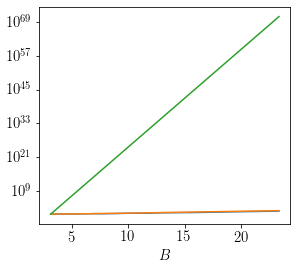

In [22]:
plt.figure(figsize=(4.5,4))
plt.plot(Bs, np.mean(l2es_B,1), label=r'$\|\hat{w}-w^*\|_2^2$')
plt.fill_between(Bs, np.mean(l2es_B,1)+2*np.std(l2es_B,1)/np.sqrt(n_iter),
                 np.mean(l2es_B,1)-2*np.std(l2es_B,1)/np.sqrt(n_iter), alpha=0.3)
plt.plot(Bs, kappa_B/lambdas_2_I_B*shift_ours, label=r'$\frac{\kappa}{\lambda_2(I(w^*))}$')
plt.plot(Bs, (np.exp(Bs)+np.exp(-Bs))**8*shift_shah, label=r'$\frac{\zeta^2}{\gamma^2\lambda_2(L)}$')
plt.xlabel(r'$B$'); plt.yscale("log"); # plt.legend()

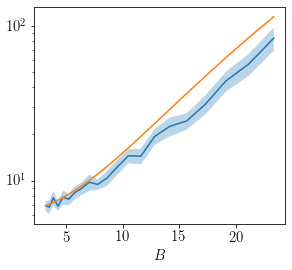

In [23]:
plt.figure(figsize=(4.5,4))
plt.plot(Bs, np.mean(l2es_B,1), label=r'$\|\hat{w}-w^*\|_2^2$')
plt.fill_between(Bs, np.mean(l2es_B,1)+2*np.std(l2es_B,1)/np.sqrt(n_iter),
                 np.mean(l2es_B,1)-2*np.std(l2es_B,1)/np.sqrt(n_iter), alpha=0.3)
plt.plot(Bs, kappa_B/lambdas_2_I_B*shift_ours, label=r'$\frac{\kappa}{\lambda_2(I(w^*))}$')
plt.xlabel(r'$B$'); plt.yscale("log")

# $\ell_2$ error rate with respect to graph topology

## parameters

In [24]:
d = 100
W = np.floor(d/np.sqrt(np.log(d))/4).astype(int)
B = np.sqrt(np.log(d))*4
T = 5

In [25]:
Ws = np.floor(np.exp(np.linspace(-1,1,21))*d/np.sqrt(np.log(d))/4).astype(int)
n_iter = 100

## simulation

In [26]:
l2es_G = np.zeros((len(Bs), n_iter))
for i, W in enumerate(Ws):
    print("%d-th W: %f"%(i, W))
    
    w_star = 2*B*np.arange(d)/d - B
    A_matrix = np.logical_and(np.arange(d)[:,None] != np.arange(d),
                   np.abs(np.arange(d)[:,None] - np.arange(d)) <= W) * T
    
    for j in np.arange(n_iter):
        _, l2e = simulate(d, w_star, A_matrix)
        l2es_G[i,j] = l2e

0-th W: 4.000000
1-th W: 4.000000
2-th W: 5.000000
3-th W: 5.000000
4-th W: 6.000000
5-th W: 7.000000
6-th W: 7.000000
7-th W: 8.000000
8-th W: 9.000000
9-th W: 10.000000
10-th W: 11.000000
11-th W: 12.000000
12-th W: 14.000000
13-th W: 15.000000
14-th W: 17.000000
15-th W: 19.000000
16-th W: 21.000000
17-th W: 23.000000
18-th W: 25.000000
19-th W: 28.000000
20-th W: 31.000000


## theoretical values

In [27]:
lambdas_2_I_G = np.zeros((len(Ws)))
lambdas_2_L_G = np.zeros((len(Ws)))
kappa_G = np.zeros((len(Ws)))

for i, W in enumerate(Ws):
    P_matrix = 1/(1+np.exp(2*B*(np.arange(d) - np.arange(d)[:,None])/d))
    A_matrix = np.logical_and(np.arange(d)[:,None] != np.arange(d),
                          np.abs(np.arange(d)[:,None] - np.arange(d)) <= W)
    L_matrix = (np.diag(np.sum(A_matrix,0)) - A_matrix) #/ np.sum(A_matrix) * 2
    B_matrix = P_matrix * (1-P_matrix) * A_matrix
    I_matrix = (np.diag(np.sum(B_matrix,0)) - B_matrix) #/ np.sum(A_matrix) * 2
    
    u, v = la.eigh(L_matrix)
    L_isqrt = v @ (np.concatenate([[0], 1/np.sqrt(u[1:])])*v).T

    lambdas_2_I_G[i] = la.eigvalsh(I_matrix)[1]
    lambdas_2_L_G[i] = la.eigvalsh(L_matrix)[1]
    kappa_G[i] = 1/la.eigvalsh(L_isqrt @ I_matrix @ L_isqrt)[-1]

## plot

In [30]:
shift_ours = np.mean(l2es_G[-1])/kappa_G[-1]*lambdas_2_I_G[-1]
shift_shah = np.mean(l2es_G[-1])*lambdas_2_L_G[-1]

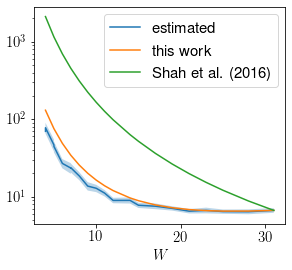

In [31]:
plt.figure(figsize=(4.5,4))
plt.plot(Ws, np.mean(l2es_G,1), label=r'estimated')
plt.fill_between(Ws, np.mean(l2es_G,1) + 2*np.std(l2es_G,1)/np.sqrt(n_iter),
                np.mean(l2es_G,1) - 2*np.std(l2es_G,1)/np.sqrt(n_iter), alpha=0.3)
plt.plot(Ws, kappa_G/lambdas_2_I_G*shift_ours, label=r'this work')
plt.plot(Ws, 1/lambdas_2_L_G*shift_shah, label=r'Shah et al. (2016)')
plt.xlabel(r'$W$'); plt.yscale("log"); plt.legend()